In [6]:
!pip install pykalman

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


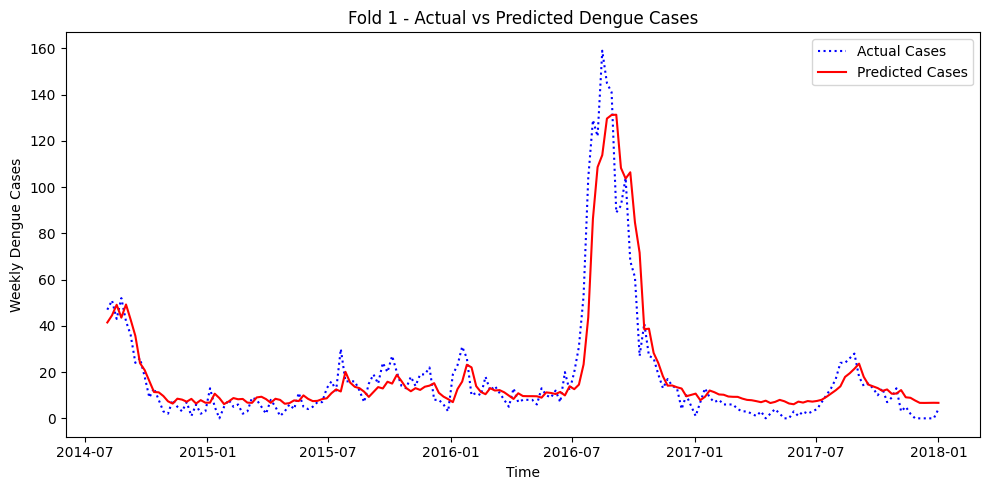

Fold 1 Metrics - MSE: 113.59, RMSE: 10.66, MAE: 6.42, R2: 0.84
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


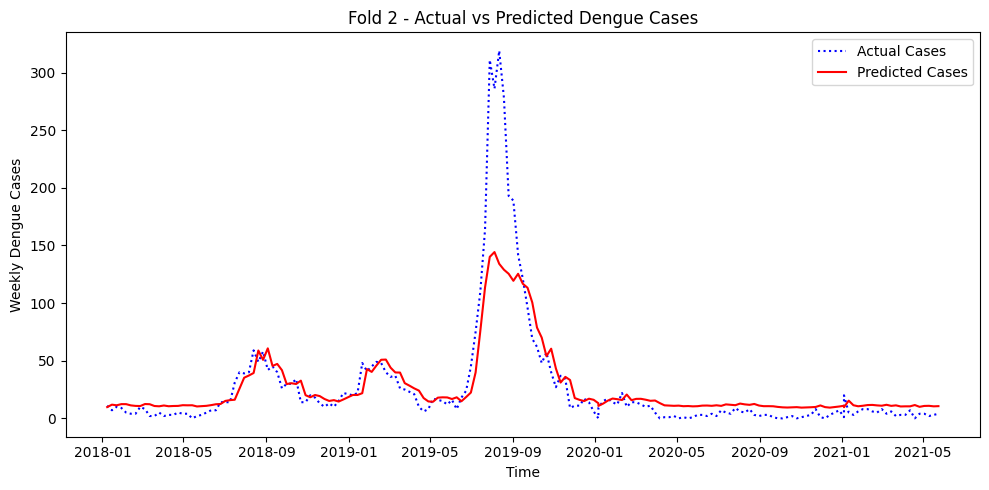

Fold 2 Metrics - MSE: 752.51, RMSE: 27.43, MAE: 12.11, R2: 0.72
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


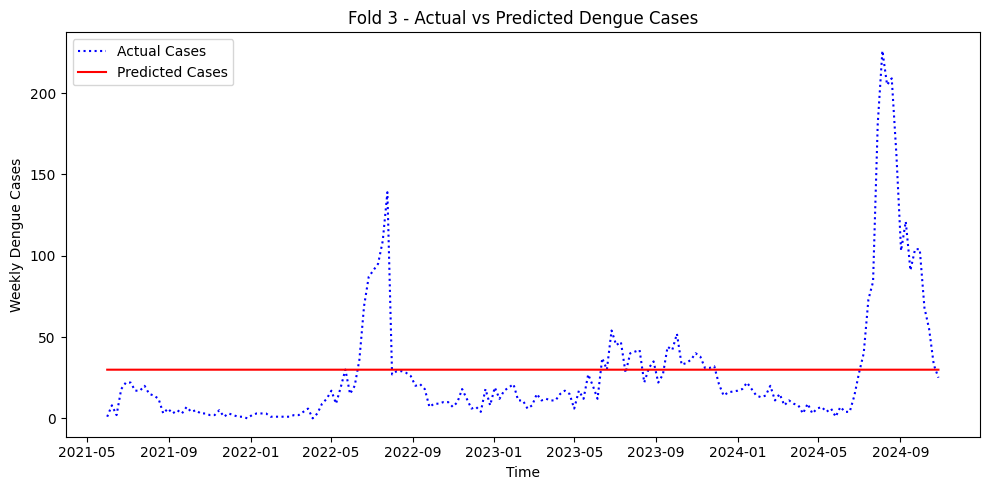

Fold 3 Metrics - MSE: 1489.95, RMSE: 38.60, MAE: 25.13, R2: -0.01

=== Average Metrics Across Folds ===
Average MSE: 785.35
Average RMSE: 25.56
Average MAE: 14.55
Average R2: 0.52


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from pykalman import KalmanFilter
from google.colab import drive

drive.mount('/content/drive')

# Load and preprocess data
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Time'] = pd.to_datetime(data['Time'] + '-1', format='%Y-w%W-%w')
    data.set_index('Time', inplace=True)
    return data

def apply_kalman_filter_features(data):
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1,
                      transition_matrices=[1], observation_matrices=[1],
                      observation_covariance=1.0, transition_covariance=0.01)
    smoothed_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        smoothed_feature, _ = kf.smooth(data[:, i])
        smoothed_data[:, i] = smoothed_feature.flatten()  # <-- flatten the (n, 1) array
    return smoothed_data


# Create sequences for LSTM input
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# Train LSTM Model
def train_lstm_model(X_train, y_train, X_val, y_val, input_shape, learning_rate=0.01, epochs=100, batch_size=1):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), verbose=0,
                        callbacks=[early_stopping])
    return model, history

# ---- Main Program ----

data = load_and_preprocess_data('/content/drive/MyDrive/Colab Notebooks/2011completefinaldatasets.csv')
features = ['Rainfall', 'MaxTemperature', 'Humidity']
target = 'Cases'

# Normalize features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
normalized_features = scaler_features.fit_transform(data[features])
normalized_target = scaler_target.fit_transform(data[target].values.reshape(-1, 1))

# Apply Kalman Filter to features
smoothed_features = apply_kalman_filter_features(normalized_features)
smoothed_data = pd.DataFrame(smoothed_features, columns=features, index=data.index)
smoothed_data['Cases'] = normalized_target

# Prepare sequences
window_size = 5
X, y = create_sequences(smoothed_data.values, normalized_target, window_size)

# TimeSeriesSplit Cross Validation
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

metrics = {'mse': [], 'rmse': [], 'mae': [], 'r2': []}

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}")

    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

    lstm_model, history = train_lstm_model(X_train, y_train, X_val, y_val, input_shape=(X_train.shape[1], X_train.shape[2]))

    y_pred = lstm_model.predict(X_val)
    y_pred_actual = scaler_target.inverse_transform(y_pred)
    y_val_actual = scaler_target.inverse_transform(y_val)

    # Metrics
    mse = mean_squared_error(y_val_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_actual, y_pred_actual)
    r2 = r2_score(y_val_actual, y_pred_actual)

    metrics['mse'].append(mse)
    metrics['rmse'].append(rmse)
    metrics['mae'].append(mae)
    metrics['r2'].append(r2)

    # Plot
    plt.figure(figsize=(10, 5))
    time_index = data.index[window_size + test_index[0]: window_size + test_index[-1] + 1]
    plt.plot(time_index, y_val_actual, label='Actual Cases', linestyle='dotted', color='blue')
    plt.plot(time_index, y_pred_actual, label='Predicted Cases', color='red')
    plt.title(f'Fold {fold+1} - Actual vs Predicted Dengue Cases')
    plt.xlabel('Time')
    plt.ylabel('Weekly Dengue Cases')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Fold {fold+1} Metrics - MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

# Display average metrics across folds
print("\n=== Average Metrics Across Folds ===")
print(f"Average MSE: {np.mean(metrics['mse']):.2f}")
print(f"Average RMSE: {np.mean(metrics['rmse']):.2f}")
print(f"Average MAE: {np.mean(metrics['mae']):.2f}")
print(f"Average R2: {np.mean(metrics['r2']):.2f}")
